#### Group Information

Group No: Climate_3

- Member 1: LIM CHIN FENG
- Member 2: OOI YONG QIN
- Member 3: GWEE PER MING
- Member 4: OOI YUE SHENG


#### Import libraries

In [1]:
%pip install mlxtend --upgrade --user

Note: you may need to restart the kernel to use updated packages.


In [2]:
%config Completer.use_jedi=False

# Import the libraries and modules that will be used in this project
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree,export_text

#### Load the dataset

In [3]:
#read the climate dataset csv file 
climate = pd.read_csv('climate.csv')

#### Split the dataset
Split the dataset into training, validation and test sets.

In [4]:
# Sort the dataset to make sure that the training, testing and validation set have the data with different outcome
#drop 'Study' and 'Run' column since it is not useful in prediction and they are only for numbering the data

climate.sort_values('outcome', inplace=True)
col = climate.drop(columns=['outcome','Study','Run']).columns
y = climate['outcome']
X = climate[col]

In [5]:
# Split the dataset to training set, testing set and validation set with the ratio of 8:2
seed_num = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=seed_num)
X_train,X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed_num)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(345, 18)
(87, 18)
(108, 18)


#### Data preprocessing
Perform data preprocessing such as normalization, standardization, label encoding etc.
______________________________________________________________________________________
##### Description: 

climate.info() is a method that is used to display a concise summary of a DataFrame.
For the test set, all the data inside the climate data set is displayed.

climate.shape() is used to obtain the size of the array of our data
For the test set, the shape of the data is calculated and shown to have in total of 540 rows and 21 columns.


Thus, after display and observing the shape of our data. We could clearly observe that all the data are non-null value, which means that we are not required to replace any data manually.

Moving on to the next step, we perform normalization on our data using MinMaxScaler.

MinMaxScaler is a scaling method that transform the data by subtracting the minimum value of each feature and dividing by the range. For our test set, the minimum value of the feature is scaled to 0 while the maximum value is scaled to 1 and other values would be scaled in between and the result is shown as below.

In [6]:
# check the information of the climate dataset
climate.info()
climate.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540 entries, 0 to 539
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Study                 540 non-null    int64  
 1   Run                   540 non-null    int64  
 2   vconst_corr           540 non-null    float64
 3   vconst_2              540 non-null    float64
 4   vconst_3              540 non-null    float64
 5   vconst_4              540 non-null    float64
 6   vconst_5              540 non-null    float64
 7   vconst_7              540 non-null    float64
 8   ah_corr               540 non-null    float64
 9   ah_bolus              540 non-null    float64
 10  slm_corr              540 non-null    float64
 11  efficiency_factor     540 non-null    float64
 12  tidal_mix_max         540 non-null    float64
 13  vertical_decay_scale  540 non-null    float64
 14  convect_corr          540 non-null    float64
 15  bckgrnd_vdc1          5

(540, 21)

In [7]:
#Normalized the data by using MinMaxScaler

# normalize the data
scaler = MinMaxScaler() # normalize data 0-1
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)
X_val_norm = scaler.transform(X_val)

# convert X_train_norm, X_test_norm, X_val_norm to a Pandas DataFrame
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns)
X_val_norm = pd.DataFrame(X_val_norm, columns=X_val.columns)

print(X_train_norm)

     vconst_corr  vconst_2  vconst_3  vconst_4  vconst_5  vconst_7   ah_corr  \
0       0.086613  0.569960  0.814199  0.112507  0.571352  0.723524  0.854969   
1       0.083660  0.701891  0.412384  0.342099  0.319628  0.732747  0.192892   
2       0.488921  0.927233  0.755736  0.872109  0.916482  0.475445  0.384935   
3       0.206774  0.855238  0.273855  0.852532  0.717980  0.084972  0.975288   
4       0.917343  0.383566  0.582905  0.658446  0.870104  0.660281  0.986264   
..           ...       ...       ...       ...       ...       ...       ...   
340     0.160832  0.548621  0.151190  0.655261  0.139755  0.798871  0.403534   
341     0.076153  0.711244  0.884965  0.121547  0.906154  0.233794  0.364506   
342     0.266311  0.081081  0.483240  0.230765  0.825838  0.526178  0.948664   
343     0.205391  0.321230  0.615433  0.006624  0.470800  0.383245  0.883003   
344     0.864225  0.014840  0.550496  0.131010  0.025591  0.795462  0.758247   

     ah_bolus  slm_corr  efficiency_fac

#### Feature Selection
Perform feature selection to select the relevant features.
______________________________________________________________________________________
##### Description:
Correlation can be referred as the statistical relationship between two variables. The range of measuring correlation coefficient is between 1 and -1, thus it is best for us to find the correlation value that is close to 0, indicating a weak linear relationship between the variables. 
A column with a correlation coefficient that is larger than 0.8 would be dropped.

col=correlation(X_train_norm,0.8)

From the test set, we search for any columns in the dataset that had a correlation coefficient that is higher than 0.8.
As a result, no columns in our data had a correlation coefficient that is higher than 0.8.

Moving on, feature selection is performed on the data. We used forward sequential feature selection for both decision tree and SVM model. Sequential feature selection (SFS) is a technique for filtering a subset of features from a large set of features in the dataset. The purpose of SFS is to improve the performance of the model. The word "Forward" in Forward sequential feature selection refers to the forward direction in which the features are selected.

By applying forward SFS on decision tree, the columns that are selected are 
- 'vconst_corr', 'vconst_2', 'slm_corr', 'vertical_decay_scale', 'convect_corr', 'bckgrnd_vdc1', 'bckgrnd_vdc_eq', 'bckgrnd_vdc_psim'and 'Prandtl'.

On the other hand, by applying forward SFS on SVM, the columns that are selected are 
- 'vconst_corr', 'vconst_2', 'slm_corr', 'efficiency_factor', 'vertical_decay_scale', 'convect_corr', 'bckgrnd_vdc1'and 'bckgrnd_vdc_eq'.

In [8]:
#drop highly correlated columns by finding the column which correlation coefficient > 0.8 
def correlation(dataset,threshold):
    col_corr=set()
    corr_matrix=pd.DataFrame(dataset).corr() 
    for i in range(len(corr_matrix.columns)): 
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold: 
                colName=corr_matrix.columns[i] 
                col_corr.add(colName) 
    return col_corr 

col=correlation(X_train_norm,0.8)
if (len(col) == 0):
    print('No columns that are hightly correlated with each others')
else:
    print('Correlated columns:',col)  
    

No columns that are hightly correlated with each others


#### Feature Selection for Decision Tree

In [9]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestClassifier

#Sequential Feature Selector (SFS) to perform feature selection with a Random Forest classifier.
feature_selector = sfs(RandomForestClassifier(n_jobs=-1, random_state=seed_num), k_features=(5,18), forward=True, floating=False, verbose=2, scoring='accuracy', cv=2)
sfs = feature_selector.fit(X_train_norm, y_train)
selected_features_decisiontree = X_train_norm.columns[list(sfs.k_feature_idx_)]
selected_features_decisiontree

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   11.8s finished

[2023-05-23 09:45:02] Features: 1/18 -- score: 0.8725131066003495[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.6s finished

[2023-05-23 09:45:08] Features: 2/18 -- score: 0.9130427476811399[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    5.2s finished

[2023-05-23 09:45:13] Features: 3/18 -- score: 0.918856701169512[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

Index(['vconst_corr', 'vconst_2', 'slm_corr', 'vertical_decay_scale',
       'convect_corr', 'bckgrnd_vdc1', 'bckgrnd_vdc_eq', 'bckgrnd_vdc_psim',
       'Prandtl'],
      dtype='object')

In [10]:
# the selected features for Decision Tree using Sequential Feature Selector 
selected_features_decisiontree =  ['vconst_corr', 'vconst_2', 'slm_corr', 'vertical_decay_scale',
       'convect_corr', 'bckgrnd_vdc1', 'bckgrnd_vdc_eq', 'bckgrnd_vdc_psim',
       'Prandtl']

#### Feature Selection for SVM

In [11]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.svm import SVC

#Sequential Feature Selector (SFS) to perform feature selection with a SVM classifier .
feature_selector_svm = sfs(SVC(kernel='poly', degree=2, gamma='scale', coef0=1, C=5, random_state=seed_num), k_features=(5,len(X_train.columns)), forward=True, floating=False, verbose=2, scoring='accuracy', cv=2)
sfs = feature_selector_svm.fit(X_train_norm, y_train)
selected_features_svm =X_train_norm.columns[list(sfs.k_feature_idx_)]
selected_features_svm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.1s finished

[2023-05-23 09:45:54] Features: 1/18 -- score: 0.9130427476811399[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished

[2023-05-23 09:45:54] Features: 2/18 -- score: 0.915949724425326[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished

[2023-05-23 09:45:54] Features: 3/18 -- score: 0.9391215217099073[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

Index(['vconst_corr', 'vconst_2', 'slm_corr', 'efficiency_factor',
       'vertical_decay_scale', 'convect_corr', 'bckgrnd_vdc1',
       'bckgrnd_vdc_eq'],
      dtype='object')

In [12]:
# the selected features for SVM using Sequential Feature Selector 
selected_features_svm =  ['vconst_corr', 'vconst_2', 'slm_corr', 'efficiency_factor',
       'vertical_decay_scale', 'convect_corr', 'bckgrnd_vdc1',
       'bckgrnd_vdc_eq']

#### Data modeling
Build the machine learning models. You must build atleast two (2) predictive models. One of the predictive models must be either Decision Tree or Support Vector Machine.
______________________________________________________________________________________
##### Description:

For data modeling, we will be doing decision tree algorithm and SVM.
As we known, the aim of decision tree algorithm is to partition the data in order to maximize the purity of the resulting subsets. Thus, this requires Gini index and entropy to help with this problem as these two index are used to provide measurements of the impurities within a subset.

For data modeling for decision tree which uses gini index, the first step we perform is inserting the features that we selected previously using forward sequential feature selection into X_train_norm_decisiontree, X_val_norm_decisiontree and X_test_norm_decisiontree. This step is a preprocessing step.  

After building the model using the <b>gini</b> , the best result for decision tree using gini index would be having a decision tree classifier with a 
- maximum depth of 5 and 
- minimum samples of split of 15
- Accuracy of gini model is 0.9195402298850575.

This process same goes to decision tree which uses <b>entropy</b>, after training the data, the best result using entropy would be having a decision tree classifier with a
- maximum depth of 3
- minimun samples of split of 15
- Accuracy of entropy model is 0.9195402298850575.

Moving on to <b>SVM</b>, the first step we perform is inserting the features that we selected using forward sequential feature selection into X_train_norm_svm , X_val_norm_svm and X_test_norm_svm. For finding the best SVM model, the 4 features that we are mainly looking for would be the kernel, C value, weighted average f1 score and the degree of the model.
After building the model, the best result of the model would be the
- poly kernel
- a regularization parameter 'C' set to 3
- weighted average f1 score of the model would be 0.951440419030991 and the degree of 2.

#### Data modeling for Decision Tree

##### 1) Data modeling for Decision Tree (gini)

In [13]:
# Use the features selected by the Forward Sequential Feature Selection with a Random Forest classifier

decisiontree_selected_features = selected_features_decisiontree
selected_features_decisiontree = list(selected_features_decisiontree)
print(selected_features_decisiontree)
X_train_norm_decisiontree = X_train_norm[selected_features_decisiontree]
X_val_norm_decisiontree = X_val_norm[selected_features_decisiontree]
X_test_norm_decisiontree = X_test_norm[selected_features_decisiontree]

['vconst_corr', 'vconst_2', 'slm_corr', 'vertical_decay_scale', 'convect_corr', 'bckgrnd_vdc1', 'bckgrnd_vdc_eq', 'bckgrnd_vdc_psim', 'Prandtl']


In [14]:
#using gini
model_dt_gini= DecisionTreeClassifier(criterion='gini',random_state=seed_num)
model_dt_gini.fit(X_train_norm_decisiontree, y_train)

DecisionTreeClassifier(random_state=0)

In [15]:
#using gini to find the optimum depth of the decision tree which has the highest accuracy
dt_models = []
depths = np.arange(3,10,1)
for d in depths:
    model = DecisionTreeClassifier(criterion='gini', min_samples_split=15 ,max_depth=d, random_state=seed_num)
    model.fit(X_train_norm_decisiontree, y_train)
    dt_models.append(model)
best_acc = 0
model_best_gini = None
for m,d in zip(dt_models, depths):
    acc = m.score(X_val_norm_decisiontree, y_val)
    print(f'Decision Tree classifier with max_depth={d} achieves a mean accuracy of {acc}')
    if acc > best_acc:
        best_acc = acc
        model_best_gini = m
        
print("\nBest gini details:")
model_best_gini

Decision Tree classifier with max_depth=3 achieves a mean accuracy of 0.896551724137931
Decision Tree classifier with max_depth=4 achieves a mean accuracy of 0.9080459770114943
Decision Tree classifier with max_depth=5 achieves a mean accuracy of 0.9195402298850575
Decision Tree classifier with max_depth=6 achieves a mean accuracy of 0.8850574712643678
Decision Tree classifier with max_depth=7 achieves a mean accuracy of 0.8850574712643678
Decision Tree classifier with max_depth=8 achieves a mean accuracy of 0.8850574712643678
Decision Tree classifier with max_depth=9 achieves a mean accuracy of 0.8850574712643678

Best gini details:


DecisionTreeClassifier(max_depth=5, min_samples_split=15, random_state=0)

##### 2) Data modeling for Decision Tree (entropy)

In [16]:
#using entropy 
model_dt_entropy= DecisionTreeClassifier(criterion='entropy',random_state=seed_num)
model_dt_entropy.fit(X_train_norm_decisiontree, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [17]:
#using entropy to find the optimum depth of the decision tree which has the highest accuracy
dt_models = []
depths = np.arange(3,10,1)
for d in depths:
    model = DecisionTreeClassifier(criterion='entropy', min_samples_split=15 ,max_depth=d, random_state=seed_num)
    model.fit(X_train_norm_decisiontree, y_train)
    dt_models.append(model)
best_acc = 0
model_best_entropy = None
for m,d in zip(dt_models, depths):
    acc = m.score(X_val_norm_decisiontree, y_val)
    print(f'Decision Tree classifier with max_depth={d} achieves a mean accuracy of {acc}')
    if acc > best_acc:
        best_acc = acc
        model_best_entropy = m

print("\nBest entropy details:")
model_best_entropy

Decision Tree classifier with max_depth=3 achieves a mean accuracy of 0.9195402298850575
Decision Tree classifier with max_depth=4 achieves a mean accuracy of 0.9195402298850575
Decision Tree classifier with max_depth=5 achieves a mean accuracy of 0.9195402298850575
Decision Tree classifier with max_depth=6 achieves a mean accuracy of 0.896551724137931
Decision Tree classifier with max_depth=7 achieves a mean accuracy of 0.896551724137931
Decision Tree classifier with max_depth=8 achieves a mean accuracy of 0.896551724137931
Decision Tree classifier with max_depth=9 achieves a mean accuracy of 0.896551724137931

Best entropy details:


DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=15,
                       random_state=0)

#### Data modeling for SVM

In [18]:
# Use the features selected by the Forward Sequential Feature Selection with a Support Vector Machine (SVM) classifier.
selected_features_svm = list(selected_features_svm)
print(selected_features_svm)
X_train_norm_svm = X_train_norm[selected_features_svm]
X_val_norm_svm = X_val_norm[selected_features_svm]
X_test_norm_svm = X_test_norm[selected_features_svm]

['vconst_corr', 'vconst_2', 'slm_corr', 'efficiency_factor', 'vertical_decay_scale', 'convect_corr', 'bckgrnd_vdc1', 'bckgrnd_vdc_eq']


In [19]:
# Determine the the best kernel with C-value

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
best_option_svm = {'kernel': None ,
                    'C': 0,
                    'weighted avg f1-score': 0,
                    'degree': 0
                    }

# repeatly test different kernel with different C value ranging from 1 to 10
for kernel in kernel:
    # len(X_train.columns)+2 is used as max so that the degree can reach until (no. of features + 1) dimensions
    max_degree = len(X_train_norm_svm.columns)+2 if kernel == 'poly' else 1

    # print statement below is used for debugging
    # print(kernel)
    
    for degree in range(1,max_degree):
        for c in range(1,11):
            # print statement below is used for debugging
            # print('Degree: {} \t C: {}\n'.format(degree,c))

            svm = SVC(kernel=kernel, C=c,degree=degree)
            svm.fit(X_train_norm_svm, y_train)
            yhat = svm.predict(X_val_norm_svm)
            f1 = f1_score(y_val, yhat, average='weighted')
            # using weighted average f1-score to find the best option instead of accuracy due to imbalance of classes
            if f1 > best_option_svm['weighted avg f1-score']:
                best_option_svm['kernel'] = kernel
                best_option_svm['C'] = c
                best_option_svm['weighted avg f1-score'] = f1
                best_option_svm['degree'] = (degree if kernel == 'poly' else None)

#Display the best kernel with the best C-value
print("\nBest SVM kernel and its details:")
best_option_svm


Best SVM kernel and its details:


{'kernel': 'poly',
 'C': 3,
 'weighted avg f1-score': 0.951440419030991,
 'degree': 2}

#### Evaluate the models
Perform a comparison between the predictive models. <br>
Report the accuracy, recall, precision and F1-score measures as well as the confusion matrix if it is a classification problem. <br>
Report the R2 score, mean squared error and mean absolute error if it is a regression problem.
______________________________________________________________________________________
##### Description: At the bottommost part, comparison is done after model performance evaluation

<br><br>

#### Evaluate the Performance of Decision Tree (gini and entropy)

##### gini

Best Depth of Gini : DecisionTreeClassifier(max_depth=5, min_samples_split=15, random_state=0)

Accuracy : 0.9259259259259259
Confusion Matrix : 
[[ 3  4]
 [ 4 97]]

Classification Report (Gini) : 
              precision    recall  f1-score   support

           0       0.43      0.43      0.43         7
           1       0.96      0.96      0.96       101

    accuracy                           0.93       108
   macro avg       0.69      0.69      0.69       108
weighted avg       0.93      0.93      0.93       108


Confusion Matrix of Decision Tree: Gini


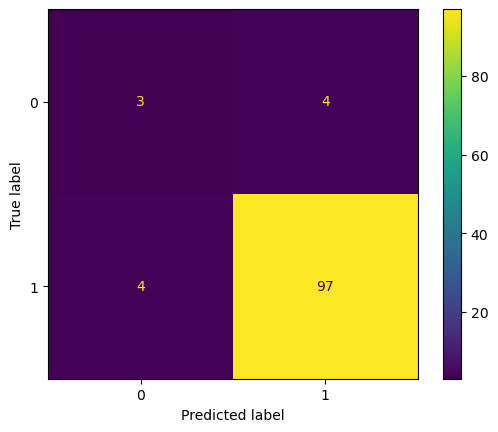

In [20]:
#Performance after apply the optimum depth of the tree which using gini

y_pred_gini = model_best_gini.predict(X_test_norm_decisiontree)
print('Best Depth of Gini : {}'.format(model_best_gini))
print('\nAccuracy : {}'.format(accuracy_score(y_test,y_pred_gini)))
print('Confusion Matrix : \n{}\n'.format(confusion_matrix(y_test,y_pred_gini)))
print('Classification Report (Gini) : ')
print(classification_report(y_test,y_pred_gini))


print('\nConfusion Matrix of Decision Tree: Gini')
cm = confusion_matrix(y_test, y_pred_gini, labels=model_best_gini.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

##### entropy

Best Depth of Entropy : DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=15,
                       random_state=0)

Accuracy : 0.9074074074074074
Confusion Matrix : 
[[ 5  2]
 [ 8 93]]

Classification Report (Entropy) : 
              precision    recall  f1-score   support

           0       0.38      0.71      0.50         7
           1       0.98      0.92      0.95       101

    accuracy                           0.91       108
   macro avg       0.68      0.82      0.72       108
weighted avg       0.94      0.91      0.92       108


Confusion Matrix of Decision Tree: Entropy


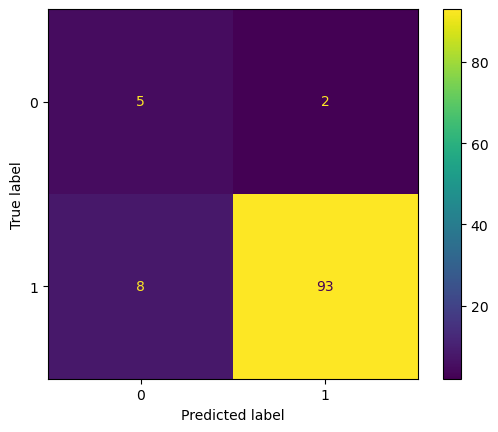

In [21]:
#Performance after apply the optimum depth of the tree which using entropy
y_pred_entropy= model_best_entropy.predict(X_test_norm_decisiontree)
print('Best Depth of Entropy : {}'.format(model_best_entropy))
print('\nAccuracy : {}'.format(accuracy_score(y_test,y_pred_entropy)))
print('Confusion Matrix : \n{}\n'.format(confusion_matrix(y_test,y_pred_entropy)))
print('Classification Report (Entropy) : ')
print(classification_report(y_test,y_pred_entropy))


print('\nConfusion Matrix of Decision Tree: Entropy')
cm = confusion_matrix(y_test, y_pred_entropy, labels=model_best_entropy.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [22]:
# The Decision Tree Rule of the better decision tree model: Gini

print('Decision Tree Rule of the best model: Gini\n\n')
print(export_text(model_best_gini, feature_names=list(X[decisiontree_selected_features].columns)))

Decision Tree Rule of the best model: Gini


|--- vconst_corr <= 0.85
|   |--- vconst_corr <= 0.57
|   |   |--- Prandtl <= 0.02
|   |   |   |--- class: 1
|   |   |--- Prandtl >  0.02
|   |   |   |--- bckgrnd_vdc1 <= 0.95
|   |   |   |   |--- class: 1
|   |   |   |--- bckgrnd_vdc1 >  0.95
|   |   |   |   |--- class: 1
|   |--- vconst_corr >  0.57
|   |   |--- bckgrnd_vdc1 <= 0.25
|   |   |   |--- vconst_2 <= 0.81
|   |   |   |   |--- convect_corr <= 0.90
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- convect_corr >  0.90
|   |   |   |   |   |--- class: 0
|   |   |   |--- vconst_2 >  0.81
|   |   |   |   |--- class: 0
|   |   |--- bckgrnd_vdc1 >  0.25
|   |   |   |--- vconst_corr <= 0.64
|   |   |   |   |--- vconst_corr <= 0.63
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- vconst_corr >  0.63
|   |   |   |   |   |--- class: 0
|   |   |   |--- vconst_corr >  0.64
|   |   |   |   |--- class: 1
|--- vconst_corr >  0.85
|   |--- vconst_2 <= 0.58
|   |   |--- vconst_corr <= 0

In [23]:
# The Decision Tree Diagram of the better decision tree model: Gini

print('Decision Tree Diagram of the best model: Gini\n\n')
plt.figure(figsize=(50,50),dpi=400)
plot_tree(model_best_gini, feature_names=list(X[decisiontree_selected_features].columns),fontsize=10)
plt.show()

Decision Tree Diagram of the best model: Gini




##### SVM

{'kernel': 'poly', 'C': 3, 'weighted avg f1-score': 0.951440419030991, 'degree': 2}

Accuracy : 0.9629629629629629
Confusion Matrix : 
[[ 5  2]
 [ 2 99]]

Classification Report : 
              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.98      0.98      0.98       101

    accuracy                           0.96       108
   macro avg       0.85      0.85      0.85       108
weighted avg       0.96      0.96      0.96       108


Confusion Matrix of SVM: Poly with C=3


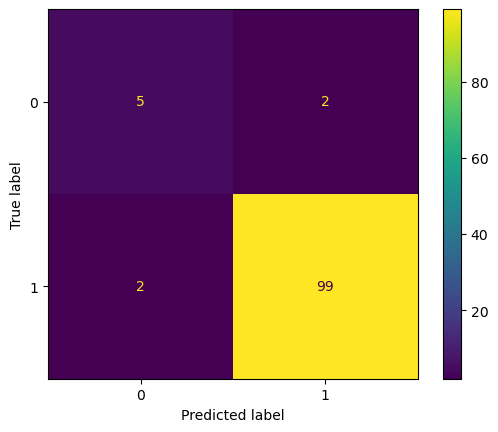

In [24]:
#Performance after apply the best kernel(Polynomial) with the best C-value(3)
model = SVC(kernel=best_option_svm['kernel'],C=best_option_svm['C'],degree = best_option_svm['degree'])
model.fit(X_train_norm_svm,y_train)
yhat = model.predict(X_test_norm_svm)

print(best_option_svm)
print('\nAccuracy : {}'.format(accuracy_score(y_test, yhat)))
print('Confusion Matrix : \n{}\n'.format(confusion_matrix(y_test, yhat)))
print('Classification Report : ')
print(classification_report(y_test, yhat))


#confusion matrix (heatmap with color-coded values)
cm = confusion_matrix(y_test, yhat)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(include_values=True, cmap='viridis')
print('\nConfusion Matrix of SVM: Poly with C=3')

#### <u>Comparison</u>

##### Description:

For this project, we built 2 models, which are SVM and Decision Tree. For Decision Tree, we will be using gini and entropy and use the better one to represent the performance of Decision Tree.


###### Gini(decision tree)
- For Gini, the best model for Gini the decision tree classifier with maximum depth of 5, minimum samples of split of 15 
- The <b>accuracy of the gini is 0.9259259259259259 </b> 

- The confusion matrix shows the number of true positives (97), true negatives (3), false positives (4), and false negatives (4).
<b>
    [[ 3  4] <br>
     [ 4 97]] <br><br>
</b>
- For the classification report, the precision for class 0 and 1 would be 0.43 and 0.96 respectively. The recall value for class 0 and class 1 would be 0.43 and 0.96 respectively. The F1-score value for class 0 and class 1 would be 0.43 and 0.96 respectively. The support value for class 0 and class 1 would be 7 and 101 respectively.

- The accuracy of the model would be 0.93. For the macro average, the precision score is 0.69, the recall value is 0.69 and the F1-score is 0.69 also. For the weighted average, the precision score is 0.93, the recall value is 0.93 and the F1-score is 0.93 also.


###### Entropy(decision tree)
- For entropy, the best model would be the model with a maximum depth of 3, minimum samples of split of 15 
- The <b>accuracy for entropy is 0.9074074074074074</b>
- The confusion matrix shows the number of true positives (93), true negatives (5), false positives (8), and false negatives (2).
<b> 
    [[ 5  2] <br>
     [ 8 93]]<br><br>
</b>
- For the classification report, the precision for class 0 and 1 would be 0.38 and 0.98 respectively. The recall value for class 0 and class 1 would be 0.71 and 0.92 respectively. The F1-score value for class 0 and class 1 would be 0.50 and 0.95 respectively. The support value for class 0 and class 1 would be 7 and 101 respectively.

- The accuracy of the model would be 0.91. For the macro average, the precision score is 0.68, the recall value is 0.82 and the F1-score is 0.72 also. For the weighted average, the precision score is 0.94, the recall value is 0.91 and the F1-score is 0.92 also.

<br><br>
<b>Comparing the Gini model and Entropy model </b>, we could conclude that <b>Gini is a better model for the decision tree algorithm</b> as the model scored a </b>higher accuracy with 0.926 </b>, comparing to entropy model with 0.907 accuracy. Aside from that, since a <b>false positive</b> prediction is <b>more impactful/dangerous</b> in the context of the dataset(model predict that the simulation will succeed, when it actually crashes), we would also like to <b>minimise the amount of false positive</b>. <b>Gini model</b> has <b>lower false positive(4)</b> than Entropy model(8). 

<br>
        Average, true positive, true negative, false negative and false positive:
<table>
<tr>
<th >Model</th>
<th>Accuracy</th>
<th>True Positive</th>
<th>True Negative</th>
<th>False Positive</th>
<th>False Negative</th>
</tr>
<tr>
<td>Gini</td>
<td>0.926</td>
<td>97</td>
<td>3</td>
<td>4</td>
<td>4</td>
</tr>
<tr>
<td>Entropy</td>
<td>0.926</td>
<td>93</td>
<td>5</td>
<td>8</td>
<td>2</td>
</tr>
</table>  
<br>

Thus, from that, we used <b>gini as the best model for decision tree</b> to build the decision tree rules and decision tree diagram.

______________________________________________________________________________________

###### SVM
- For SVM, we had already achieved the best model from the previous process. The model was trained using 'poly' kernel with a regularization parameter 'C' set to 3. 

- The <b>accuracy of SVM is 0.9629629629629629.</b>

- The confusion matrix shows the number of true positives (99), true negatives (5), false positives (2), and false negatives (2).
<b> 
    [[ 5  2] <br>
     [ 2 99]]<br><br>
</b> 

- The precision, recall, and F1-score for class 0 are 0.71, 0.71, and 0.71, respectively. The precision, recall, and F1-score for class 1 are 0.98, 0.98, and 0.98, respectively. The model had also achieved an overall macro average precision, recall and F1-score of 0.96. On the other hand, the overall weighted average precision, recall and F1-score for the model are 0.85.

______________________________________________________________________________________

##### Comparision Between Decision Tree(gini) and SVM

In comparison with Gini, the best model of decision tree and SVM, the <b>best model would be the SVM model.</b> This is because SVM had 
- a better accuracy(0.963) when compared to Decision Tree(gini - 0.926)
- a higher number of true positive (99) than Decision Tree(gini - 97)
- a higher number of true negative (5) than Decision Tree(gini - 3)
- a lower number of false negative (2) than Decision Tree(gini - 4)
- a lower number of false positive (2) than Decision Tree(gini - 4)

        Average, true positive, true negative, false negative and false positive:
<table>
<tr>
<th >Model</th>
<th>Accuracy</th>
<th>True Positive</th>
<th>True Negative</th>
<th>False Positive</th>
<th>False Negative</th>
</tr>
<tr>
<td>SVM</td>
<td>0.963</td>
<td>99</td>
<td>5</td>
<td>2</td>
<td>2</td>
</tr>
<tr>
<td>Decision Tree - Gini</td>
<td>0.926</td>
<td>97</td>
<td>3</td>
<td>4</td>
<td>4</td>
</tr>
</table>       
        


- SVM shows a higher precision, recall and F1-score for class 0 compared to Gini. The table below shows the Precision, Recall, and F1-Score of Decision Tree and SVM for Class 0 :

        Precision, Recall, and F1-Score for Class 0:
<table>
<tr>
<th  style="width:50%" >Model</th>
<th>Precision</th>
<th>Recall</th>
<th>F1-Score</th>
</tr>
<tr>
<td  style="width:50%">SVM</td>
<td>0.71</td>
<td>0.71</td>
<td>0.71</td>    
</tr>
<tr>
<td  style="width:50%">Decision Tree - Gini</td>
<td>0.43</td>
<td>0.43</td>
<td>0.43</td>
</tr>
</table>

- SVM scored a slight higher precision, recall and F1-score for class 1 when compared to Gini. The table below shows the Precision, Recall, and F1-Score of Decision Tree and SVM for Class 1 :

        Precision, Recall, and F1-Score for Class 1:

<table>
<tr>
<th  style="width:50%" >Model</th>
<th>Precision</th>
<th>Recall</th>
<th>F1-Score</th>
</tr>
<tr>
<td  style="width:50%">SVM</td>
<td>0.98</td>
<td>0.98</td>
<td>0.98</td>    
</tr>
<tr>
<td  style="width:50%">Decision Tree - Gini</td>
<td>0.96</td>
<td>0.96</td>
<td>0.96</td>
</tr>
</table>

- SVM demonstrate a higher macro average and weigted average F1-scores when compared to Gini. The table below shows the Macro Average F1-Score and Weighted Average F1-Score of Decision Tree and SVM:

         Macro Average F1-Score and Weighted Average F1-Score:
<table>
<tr>
<th  style="width:30%" >Model</th>
<th>Macro Avg F1-Score</th>
<th>Weighted Avg F1-Score</th>
</tr>
<tr>
<td  style="width:30%">SVM</td>
<td>0.85</td>
<td>0.96</td>   
</tr>
<tr>
<td  style="width:30%">Decision Tree - Gini</td>
<td>0.69</td>
<td>0.93</td>
</tr>
</table>

<br><br>
Thus, in conclusion, SVM is a clear winner when compared to Gini. <b>The best model for our project(climate dataset) would be SVM</b> due to the higher accuracy, higher number of true positive and true negative, lower number of false negative and false positive, higher precision, recall, F1-Score, Macro Average F1-Score and Weighted Average F1-Score.

##### Reference

Johannes S. Fischer. (2021, August 6). Correlation-based Feature Selection in Python from Scratch – Johannes S. Fischer. Johfischer. https://johfischer.com/2021/08/06/correlation-based-feature-selection-in-python-from-scratch/Myrianthous, 

G. (2021, April 17). How to Split a Dataset Into Training and Testing Sets with Python. Medium. https://towardsdatascience.com/how-to-split-a-dataset-into-training-and-testing-sets-b146b1649830#:~:text=The%20simplest%20way%20to%20splitscikit-learn 

developers. (n.d.-a). 1.4. Support Vector Machines. Scikit-Learn. https://scikit-learn.org/stable/modules/svm.html#:~:text=Support%20vector%20machines%20(SVMs)%20arescikit-learn 

developers. (n.d.-b). 1.10. Decision Trees. Scikit-Learn. https://scikit-learn.org/stable/modules/tree.html#:~:text=DecisionTreeClassifier%20is%20a%20class%20capablescikit-learn 

developers. (n.d.-c). sklearn.feature_selection.SequentialFeatureSelector. Scikit-Learn. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.htmlVerma

J. (2022, August 4). 2 Easy Ways to Normalize data in Python | DigitalOcean. Www.digitalocean.com. https://www.digitalocean.com/community/tutorials/normalize-data-in-python

